In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from AnalyticFormulas import MertonJumpDiffusionPrice
from sklearn.model_selection import train_test_split, GridSearchCV #, RandomizedSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from math import ceil

## Option Prices

In [2]:
r = 0.07
sigma = 0.15
lam = 2
mu_j = 0.
sig_j = 0.1
s = 80
T = 1.
strikes = np.linspace(40, 300, 12500)
moneyness = s / strikes
prices = np.array([MertonJumpDiffusionPrice(s, r, sigma, T, k, mu_j, sig_j, lam) for k in strikes])
pricesNorm = prices / strikes

Text(0.5, 1.0, 'Normalized Call Prices in Merton Jump Diffusion Model')

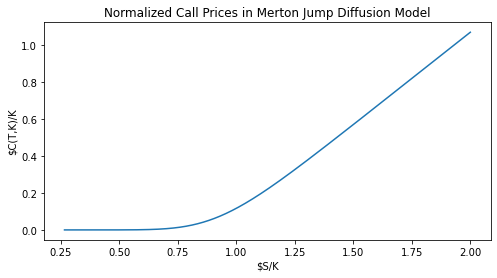

In [3]:
plt.figure(figsize=(8,4))
plt.plot(moneyness, pricesNorm)
plt.xlabel('$S/K')
plt.ylabel('$C(T,K)/K')
plt.title('Normalized Call Prices in Merton Jump Diffusion Model')

## Neural Net

In [4]:
X = np.reshape(moneyness, (len(moneyness), 1))
y = pricesNorm
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [5]:
def create_model(n_weights=1000, hidden_layers=1, learning_rate=0.001):
    # formulas derived from nWeights = sum (d(l-1)+1)*d(l) for all layers l with output dim d(l)
    if hidden_layers == 1: # 100% of neurons in first hidden layer
        neurons = [ceil((n_weights - 1) / 3)]
    elif hidden_layers == 2: # 70% / 30% split of neurons
        x = 1/7 * (np.sqrt(21 * n_weights + 79) - 10)
        neurons = list(map(ceil,[7/3 * x, x]))
    elif hidden_layers == 3: # 50% / 30% / 20% split
        x = 1/21 * (np.sqrt(84 * n_weights + 205) - 17)
        neurons = list(map(ceil, [5/2 * x, 3/2 * x, x]))
    else:
        raise Exception('Only 1, 2 or 3 layers allowed')
        
    model = Sequential([Dense(neurons[0], activation='relu', input_dim=1)])
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


In [6]:
earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

batch_size = [16, 32, 64, 128, 256, 512, 1024, 2048]
learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
hidden_layers = [1]
n_weights = [10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000]

p_grid = dict(n_weights=n_weights, hidden_layers=hidden_layers, batch_size=batch_size, learning_rate=learning_rate)
#p_grid = dict(n_weights=n_weights, batch_size=batch_size, learning_rate=learning_rate)

results = {}

model = KerasRegressor(create_model, epochs=5000, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, cv=5, verbose=1)
#grid_result = grid.fit(X_train, y_train, callbacks=[earlyStop])
grid_result = grid.fit(X_train, y_train, callbacks=[earlyStop])
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))



Fitting 5 folds for each of 616 candidates, totalling 3080 fits
Best: -4.542171326560318e-11 using {'batch_size': 512, 'hidden_layers': 1, 'learning_rate': 0.0001, 'n_weights': 30000}


In [7]:
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -4.542171326560318e-11 using {'batch_size': 512, 'hidden_layers': 1, 'learning_rate': 0.0001, 'n_weights': 30000}
-0.007924 (0.015553) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 10}
-0.000311 (0.000260) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 30}
-0.000099 (0.000104) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 60}
-0.002662 (0.004842) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 100}
-0.007560 (0.015063) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 300}
-0.030991 (0.015457) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 600}
-0.038936 (0.001063) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 1000}
-0.038464 (0.001840) with: {'batch_size': 16, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 3000}
-0.038353 (0.001450) with: {'batc

In [8]:
columns = ['mean_fit_time', 'param_batch_size', 'param_hidden_layers', 'param_learning_rate', 'param_n_weights', 'mean_test_score', 'rank_test_score']
#columns = ['mean_fit_time', 'param_batch_size', 'param_learning_rate', 'param_n_weights', 'mean_test_score', 'rank_test_score']
result_df = pd.DataFrame(grid_result.cv_results_,)[columns]
result_df.columns = ['fit_time', 'batch_size', 'hidden_layers', 'learning_rate', 'n_weights', 'test_score', 'rank']
#result_df.columns = ['fit_time', 'batch_size', 'learning_rate', 'n_weights', 'test_score', 'rank']
result_df[['batch_size', 'hidden_layers', 'n_weights']] = result_df[['batch_size', 'hidden_layers', 'n_weights']].astype(int)
#result_df[['batch_size', 'n_weights']] = result_df[['batch_size', 'n_weights']].astype(int)
result_df['learning_rate'] = result_df['learning_rate'].astype('float')
result_df['test_score'] = -result_df['test_score']
result_df['actual_weights'] = result_df[['hidden_layers', 'n_weights']].apply(lambda x: create_model(x[1], x[0]).count_params(), axis=1)
#result_df['actual_weights'] = result_df['n_weights'].apply(lambda x: create_model(x).count_params())
result_df.head()

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
0,6.160881,16,1,0.1,10,0.007924,485,10
1,6.516264,16,1,0.1,30,0.000311,421,31
2,6.419425,16,1,0.1,60,0.000099,419,61
3,9.390277,16,1,0.1,100,0.002662,447,100
4,11.127829,16,1,0.1,300,0.007560,480,301


In [9]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fit_time        616 non-null    float64
 1   batch_size      616 non-null    int32  
 2   hidden_layers   616 non-null    int32  
 3   learning_rate   616 non-null    float64
 4   n_weights       616 non-null    int32  
 5   test_score      616 non-null    float64
 6   rank            616 non-null    int32  
 7   actual_weights  616 non-null    int64  
dtypes: float64(3), int32(4), int64(1)
memory usage: 29.0 KB


In [10]:
result_df.describe()

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
count,616.000000,616.000000,616.0,616.000000,616.000000,6.160000e+02,616.000000,616.000000
mean,49.611123,510.000000,1.0,0.023800,4645.454545,7.042373e-03,308.500000,4646.090909
std,126.617142,663.063891,0.0,0.035204,8583.268359,1.548948e-02,177.968162,8583.347638
min,2.722916,16.000000,1.0,0.000100,10.000000,4.542171e-11,1.000000,10.000000
25%,8.818856,56.000000,1.0,0.000500,60.000000,1.142324e-08,154.750000,61.000000
50%,17.493598,192.000000,1.0,0.005000,600.000000,3.308516e-06,308.500000,601.000000
75%,37.636010,640.000000,1.0,0.050000,6000.000000,4.682596e-03,462.250000,6001.000000
max,1757.006976,2048.000000,1.0,0.100000,30000.000000,1.312900e-01,616.000000,30001.000000


In [11]:
idx = result_df.groupby(['n_weights'])['test_score'].transform(min) == result_df['test_score']
best_results = result_df[idx].sort_values('n_weights')
best_results

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
165,15.514692,64,1,0.0500,10,9.625913e-05,416,10
463,40.144400,1024,1,0.1000,30,7.937190e-06,338,31
244,5.046499,128,1,0.0500,60,1.980432e-06,305,61
322,3.845114,256,1,0.0500,100,3.311368e-07,266,100
411,3.717854,512,1,0.0100,300,6.628068e-08,223,301
412,6.182859,512,1,0.0100,600,6.083581e-09,136,601
413,8.857304,512,1,0.0100,1000,6.068177e-10,70,1000
491,93.952042,1024,1,0.0100,3000,1.638301e-10,23,3001
503,94.007295,1024,1,0.0050,6000,6.290819e-11,4,6001
427,116.671858,512,1,0.0050,10000,5.699416e-11,3,10000


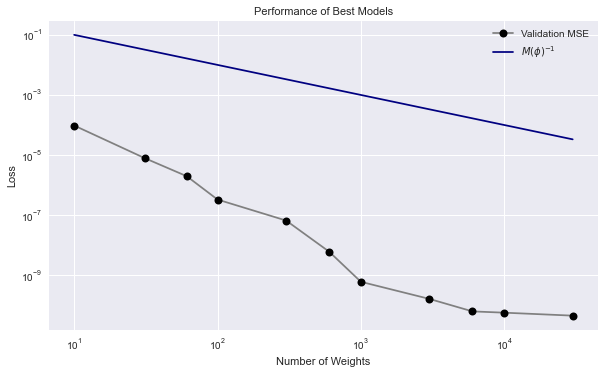

In [12]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8.5,5.3))
ax.plot(best_results['actual_weights'], best_results['test_score'], '-o', c='gray', mfc='k', mec='k', markersize=8, label='Validation MSE')
ax.plot(best_results['actual_weights'], 1 / best_results['actual_weights'], c='navy', label='$M(\phi)^{-1}$')
ax.set_xlabel('Number of Weights')
ax.set_ylabel('Loss')
ax.set_title('Performance of Best Models', fontsize=11)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.tight_layout()

In [13]:
result_df.to_csv('grid_search_Merton_20220113.csv')

In [14]:
overview = best_results.drop(['actual_weights', 'rank'], axis=1)
overview = overview[['n_weights', 'hidden_layers', 'test_score', 'learning_rate', 'batch_size', 'fit_time']]
#overview.set_index('n_weights', inplace=True)
overview.columns = ['Weights', 'Hidden Layers', 'Validation MSE', 'Learning Rate', 'Batch Size', 'Training Time (s)']
overview['Validation MSE'] = overview['Validation MSE'].apply(lambda x: '{:.2e}'.format(x))
overview['Learning Rate'] = overview['Learning Rate'].apply(lambda x: '{:g}'.format(x))
overview['Training Time (s)'] = overview['Training Time (s)'].apply(lambda x: '{:.2f}'.format(x))
overview

,Weights,Hidden Layers,Validation MSE,Learning Rate,Batch Size,Training Time (s)
165,10,1,9.63e-05,0.05,64,15.51
463,30,1,7.94e-06,0.1,1024,40.14
244,60,1,1.98e-06,0.05,128,5.05
322,100,1,3.31e-07,0.05,256,3.85
411,300,1,6.63e-08,0.01,512,3.72
412,600,1,6.08e-09,0.01,512,6.18
413,1000,1,6.07e-10,0.01,512,8.86
491,3000,1,1.64e-10,0.01,1024,93.95
503,6000,1,6.29e-11,0.005,1024,94.01
427,10000,1,5.70e-11,0.005,512,116.67


In [15]:
print(overview.to_latex(index=False))

\begin{tabular}{rrllrl}
\toprule
 Weights &  Hidden Layers & Validation MSE & Learning Rate &  Batch Size & Training Time (s) \\
\midrule
      10 &              1 &       9.63e-05 &          0.05 &          64 &             15.51 \\
      30 &              1 &       7.94e-06 &           0.1 &        1024 &             40.14 \\
      60 &              1 &       1.98e-06 &          0.05 &         128 &              5.05 \\
     100 &              1 &       3.31e-07 &          0.05 &         256 &              3.85 \\
     300 &              1 &       6.63e-08 &          0.01 &         512 &              3.72 \\
     600 &              1 &       6.08e-09 &          0.01 &         512 &              6.18 \\
    1000 &              1 &       6.07e-10 &          0.01 &         512 &              8.86 \\
    3000 &              1 &       1.64e-10 &          0.01 &        1024 &             93.95 \\
    6000 &              1 &       6.29e-11 &         0.005 &        1024 &             94.01 \

In [16]:
X

array([[2.        ],
       [1.99896046],
       [1.99792199],
       ...,
       [0.26670365],
       [0.26668516],
       [0.26666667]])

In [17]:
X_train

array([[0.35530982],
       [1.32072381],
       [1.68166835],
       ...,
       [0.31863054],
       [1.0015425 ],
       [1.06299832]])